# Clustering

In [59]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import requests
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

import sklearn.datasets as sk_data
import sklearn.metrics as metrics
import seaborn as sns

from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
print('')

In [3]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\hx}{\hat{\mathbf x}}$
$\newcommand{\vbt}{{\mathbf\beta}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

## Clustering

Clustering is a way of discovering a particular type of **structure** in a data set. Many real-world data sets exhibit this kind of structure (potentially in addition to other kinds of structure):

* Locations where millionaires live
* The number of hours people work each week
* Demographics ("soccer moms", "bored retirees", "unemployed millenials", etc.)

In most approaches that represent or employ clustering, we first find clusters and then __interpret__ them by assigning a label or category to each cluster. Thus, clustering is an example of __unsupervised__ learning:

* __Supervised__ methods:  Data items have labels, and we want to learn a function that correctly assigns labels to new data items.
* __Unsupervised__ methods:  Data items do not have labels, and we want to learn a function that extracts  important patterns from the data.

### Feature scaling

When constructing or selecting a distance metric, one needs to think carefully about the scale of the features being used.

For example, consider the case where we are clustering people based on their age, income, and gender. We might use age in years, income in dollars, and assign gender to the values $\{0, 1\}$. Suppose we have the following data set entries:

* Joe Smith, age 27, income USD 75,000, male
* Eve Jones, age 45, income USD 42,000, female

The above entries would be encoded in a feature space as follows:

$$\mat{{c}27\\75000\\0},\mat{{c}45\\42000\\1} $$

What would happen if we used Euclidean distance as our dissimilarity metric in this feature space?

Clearly, the influence of income would dominate the other two features.  For example, a difference of gender is about as significant as a difference of one dollar of yearly income. We are unlikely to expose gender-based differences if we cluster using this representation.

The most common way to handle this is __feature scaling__: rescale each feature dimension separately, so that its range of values is about the same as all of other features. For example, one may choose to:
* Shift each feature independently by subtracting the mean over all observed values (this centers each feature on zero)
* Rescale each feature so that the standard deviation over all observed values is 1 (then the feature will have about the same range of values as all the others)

As an example, we will consider Bortkiewicz's famous horse-kick data set.

In [33]:
# source: http://www.randomservices.org/random/data/HorseKicks.html
import pandas as pd
import requests
data = requests.get('https://www.randomservices.org/random/data/HorseKicks.txt').text
open('HorseKicks.txt', 'w').write(data)
df = pd.read_table('HorseKicks.txt', index_col='Year',dtype='float')
counts = df.sum(axis=1)
counts

Year
1875.0     3.0
1876.0     5.0
1877.0     7.0
1878.0     9.0
1879.0    10.0
1880.0    18.0
1881.0     6.0
1882.0    14.0
1883.0    11.0
1884.0     9.0
1885.0     5.0
1886.0    11.0
1887.0    15.0
1888.0     6.0
1889.0    11.0
1890.0    17.0
1891.0    12.0
1892.0    15.0
1893.0     8.0
1894.0     4.0
dtype: float64

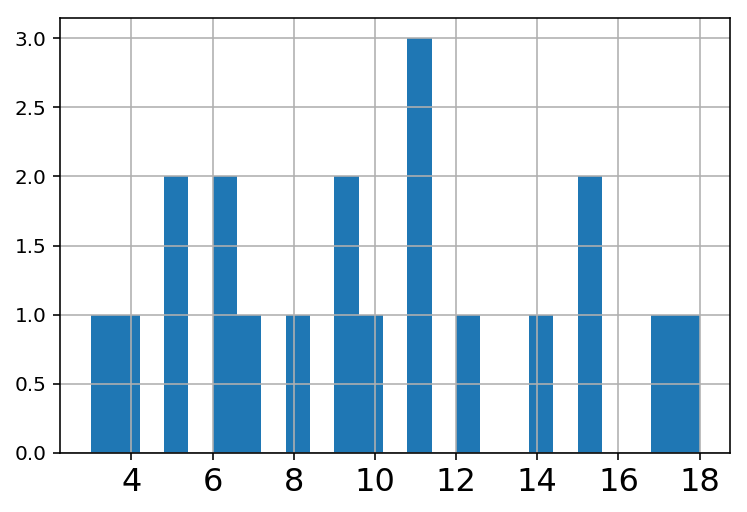

In [32]:
_ = counts.hist(bins=25,xlabelsize=16)

In [8]:
counts.mean()

9.8

To standardize to zero mean and unit standard deviation, we can use tools from the `scikit-learn` library.

           0
0  -1.586984
1  -1.120224
2  -0.653464
3  -0.186704
4   0.046676
5   1.913716
6  -0.886844
7   0.980196
8   0.280056
9  -0.186704
10 -1.120224
11  0.280056
12  1.213576
13 -0.886844
14  0.280056
15  1.680336
16  0.513436
17  1.213576
18 -0.420084
19 -1.353604
standard deviation: [1.02597835]


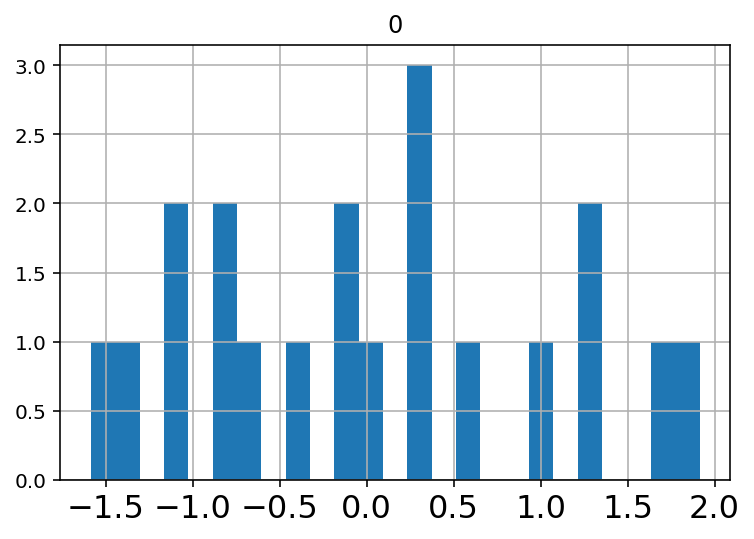

In [38]:
from sklearn import preprocessing
counts_scaled = pd.DataFrame(preprocessing.scale(counts))
print(counts_scaled)
_ = counts_scaled.hist(bins=25,xlabelsize=16)

Note that the mean for the scaled data set is now near 0 and the standard deviation is about 1.

In [40]:
print('mean:', counts_scaled.mean().values)
print('standard deviation:', counts_scaled.std().values)

mean: [-1.33226763e-16]
standard deviation: [1.02597835]


Values that were zero before have now become negative. In some situations, it may not be sensible to change zeros into something else. It may make more sense to map all values into a fixed range, for example $[0, 1]$.

           0
0   0.000000
1   0.133333
2   0.266667
3   0.400000
4   0.466667
5   1.000000
6   0.200000
7   0.733333
8   0.533333
9   0.400000
10  0.133333
11  0.533333
12  0.800000
13  0.200000
14  0.533333
15  0.933333
16  0.600000
17  0.800000
18  0.333333
19  0.066667


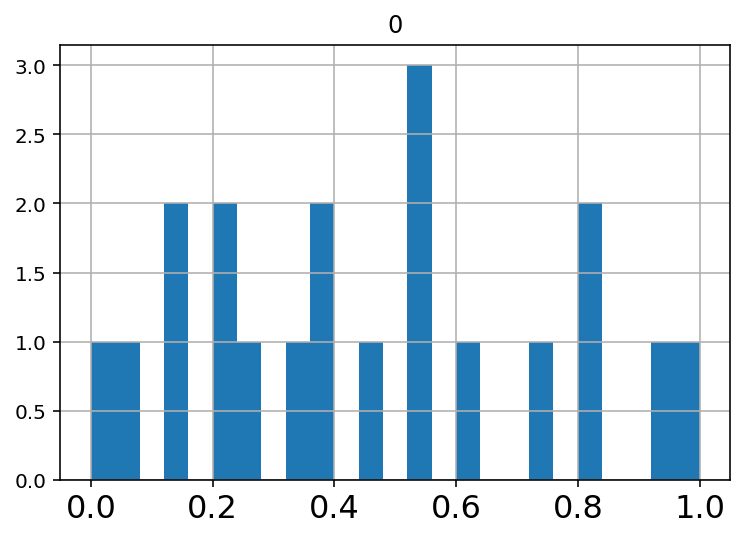

In [41]:
min_max_scaler = preprocessing.MinMaxScaler()
counts_minmax = min_max_scaler.fit_transform(counts.values.reshape(-1,1))
counts_minmax = pd.DataFrame(counts_minmax)
print(counts_minmax)
_ = counts_minmax.hist(bins=25,xlabelsize=16)

## Clustering examples with synthetic data

We consider an extended example showing how k-means clustering can be applied in practice using the Python scikit-learn libraries. Our goals include understanding:

* How clustering is used in practice
* Tools for evaluating the quality of a clustering output
* Tools for assigning meaning or labels to a cluster
* Common visualizations of results
* A little bit about feature extraction for text

### Generating data

When developing a new unsupervised method, it's a good idea to try it on a data set for which you already know the "right" answer. One way to do this is to generate synthetic data that has some known properties.

The [scikit-learn](http://scikit-learn.org/stable/documentation.html) library makes available a variety of common machine learning functions.

Among other things, it also provides tools for generating synthetic data for testing.

The ```make_blobs``` function will generate a data set of naturally clustered points (a mixture of spherical Gaussians with standard deviation 1 in each coordinate), along with a vector of labels indicating which points belongs to which blob.

We'll start by generating points in the plane:

[[ 4.68712586  1.58702856]
 [ 1.0570736   8.99447715]
 [ 5.05778701  1.64031723]
 [ 0.33864231  8.39483437]
 [ 0.90398719  7.18755672]
 [ 1.60462801  8.76392362]
 [-4.20127668  5.39794448]
 [-2.10438722  5.92331576]
 [ 4.7828298   2.20278916]
 [ 1.31821806  8.24483349]
 [ 2.68163072  8.73655757]
 [ 3.18283084  9.8099545 ]
 [ 4.57619748  0.25908363]
 [ 3.48531937 10.07693342]
 [-3.79856285  5.00932598]
 [ 5.978094    2.70137198]
 [-3.15226055  5.17228624]
 [ 1.13939388  6.88129205]
 [-3.12204963  7.54910724]
 [-4.15819137  5.8879296 ]
 [-3.69742643  3.61236137]
 [-3.09309084  4.66767102]
 [-2.4136765   4.21880848]
 [ 1.06475441  6.62677819]
 [ 3.03978242  2.84977905]
 [ 4.23744714  2.19731668]
 [ 3.34061897  2.33457651]
 [ 2.9453852   2.69615381]
 [-3.42298986  5.59638535]
 [-2.28201748  6.65926868]
 [ 2.09658373 10.06184816]
 [ 5.59878724  3.6912165 ]
 [ 3.69691606  1.04787251]
 [ 3.44661923  8.40241639]
 [-3.50934053  5.85324368]
 [-0.67066325  6.78024401]
 [ 1.84932131  9.01817316]
 

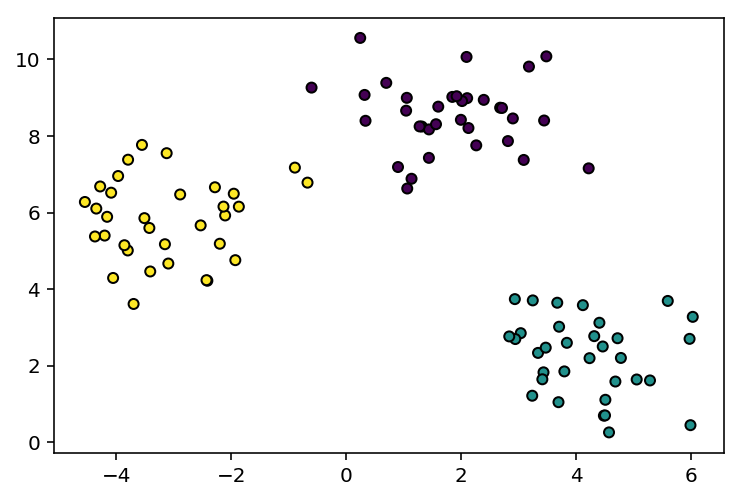

In [56]:
(points, labels) = sk_data.make_blobs(n_samples=100, centers=3, n_features=2, 
                                      center_box=(-20.0, 20.0),random_state=0)

print(points)
print(labels)
plt.scatter(points[:, 0], points[:, 1], marker='o', c=labels, s=25, edgecolor='k')

A more realistic scenario is one in which our data set has many more feature dimensions (e.g., 30).

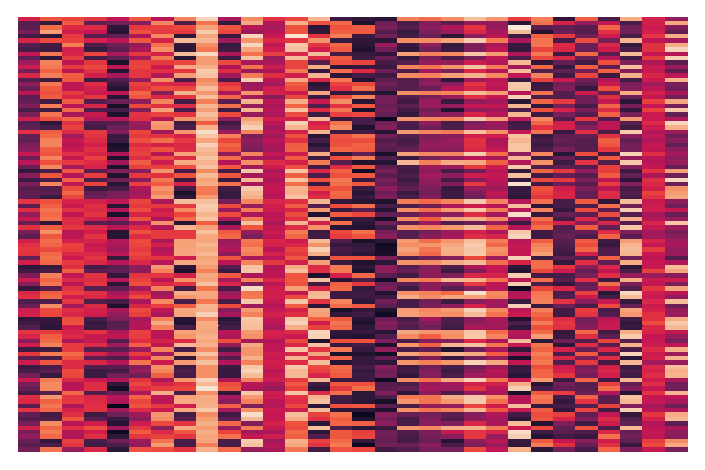

In [61]:
(X, y) = sk_data.make_blobs(n_samples=100, centers=3, n_features=30,
                            center_box=(-10.0, 10.0),random_state=0)

_ = sns.heatmap(X, xticklabels=False, yticklabels=False, linewidths=0, cbar=False)

We can try to compute pairwise distances for visualization purposes. The `sklearn.metrics` functions can help (documentation can be found [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)).

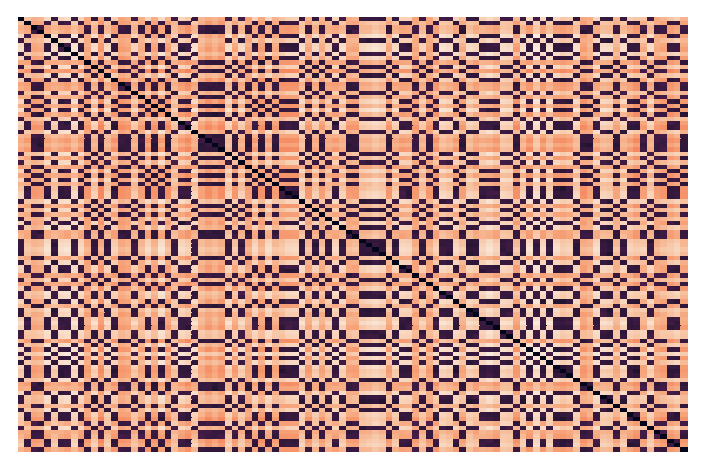

In [62]:
euclidean_dists = metrics.euclidean_distances(X)
_ = sns.heatmap(euclidean_dists, xticklabels=False, yticklabels=False, linewidths=0, cbar=False)

These data points live in a __30 dimensional__ space, so we cannot directly visualize them. We will need some additional techniques to tractably visualize this data.

### Low-dimensional embeddings

It is sometimes (but not always) possible to get a nice two-dimensional representation of a data set that we can visualize. An __embedding__ is a function that maps a data set that lives in one metric space into a different one.

To visualize a data set with a large number of feature dimensions, we can try to embed it into the plane $\mathbb{R}^2$. There are many ways to do so; we will consider one: __multidimensional scaling__ (MDS).

Given a dissimilarity or distance matrix that specifies the distances between all pairs of data points, find a set of coordinates (in the desired vector space, such as $\R^2$) for the points that approximates those distances as well as possible.

One way this can be done is via a gradient descent algorithm that starts with random positions and moves points in a way that reduces the disparity between true distance and the Euclidean distance.

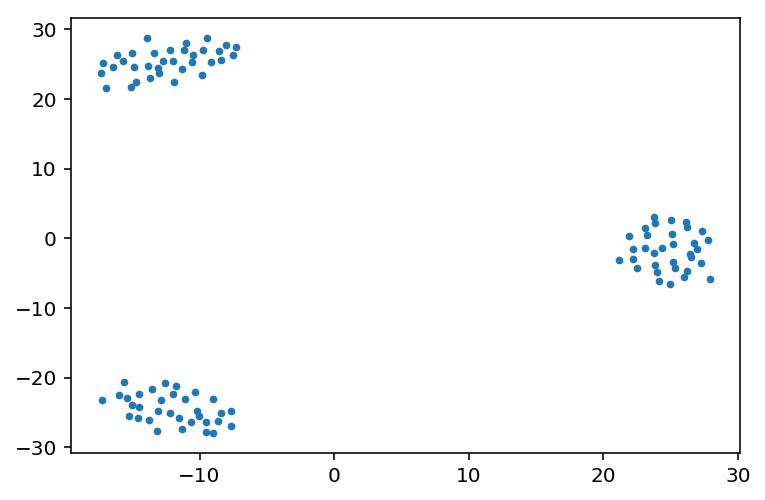

In [63]:
import sklearn.manifold
mds = sklearn.manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=0,
                   dissimilarity="precomputed", n_jobs=1)
fit = mds.fit(euclidean_dists)
pos = fit.embedding_
_ = plt.scatter(pos[:, 0], pos[:, 1], s=8)

### Applying specific clustering algorithms

The __`scikit-learn`__ library has an extensive set of tools for unsupervised learning generally, and clustering specifically; these are found in [`sklearn.cluster`](http://scikit-learn.org/stable/modules/clustering.html).

There are 3 functions in all of the clustering classes:

* __`fit()`__: builds the model from the training data (e.g., for k-means, it finds the centroids) 
* __`predict()`__: assigns labels to the data after building the model
* __`fit_predict()`__: does both at the same time

In [73]:
from sklearn.cluster import KMeans
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=100)
y_predicted = kmeans.fit_predict(X)
print(y)
print(y_predicted)
y_predicted = [1-b if b < 2 else b for b in y_predicted]
y == y_predicted
set(zip(y, y_predicted))

[0 2 1 1 2 0 2 2 0 2 1 0 1 0 2 1 1 0 1 2 1 2 1 0 2 2 0 1 1 1 1 0 1 0 1 2 1
 2 1 2 2 2 0 1 0 1 0 2 0 1 1 0 0 0 0 1 0 2 2 1 0 1 2 0 0 2 1 0 0 2 2 2 0 0
 1 0 2 0 2 0 2 2 2 0 1 1 2 0 0 1 0 2 2 1 0 1 1 2 2 1]
[0 1 2 2 1 0 1 1 0 1 2 0 2 0 1 2 2 0 2 1 2 1 2 0 1 1 0 2 2 2 2 0 2 0 2 1 2
 1 2 1 1 1 0 2 0 2 0 1 0 2 2 0 0 0 0 2 0 1 1 2 0 2 1 0 0 1 2 0 0 1 1 1 0 0
 2 0 1 0 1 0 1 1 1 0 2 2 1 0 0 2 0 1 1 2 0 2 2 1 1 2]


{(0, 1), (1, 2), (2, 0)}

All the tools in `scikit-learn` are implemented as Python objects. Thus, the general sequence for using a tool from `scikit-learn` is:

* Create the object, probably with some parameter settings or intialization
* Run the method, generally by using the `fit()` function
* Examine the results, which are generally instance variables of the object

In [75]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

print("The total error of the clustering is: {}.".format(error))
print('\nCluster labels:')
print(labels)
print('\nCluster centroids:')
print(centroids)

The total error of the clustering is: 2733.8430818977895.

Cluster labels:
[0 1 2 2 1 0 1 1 0 1 2 0 2 0 1 2 2 0 2 1 2 1 2 0 1 1 0 2 2 2 2 0 2 0 2 1 2
 1 2 1 1 1 0 2 0 2 0 1 0 2 2 0 0 0 0 2 0 1 1 2 0 2 1 0 0 1 2 0 0 1 1 1 0 0
 2 0 1 0 1 0 1 1 1 0 2 2 1 0 0 2 0 1 1 2 0 2 2 1 1 2]

Cluster centroids:
[[ 0.88697885  4.29142902  1.93200132  1.10877989 -1.55994342  2.80616392
  -1.11495818  7.74595341  8.92512875 -2.29656298  6.09588722  0.47062896
   1.36408008  8.63168509 -8.54512921 -8.59161818 -9.64308952  6.92270491
   5.65321496  7.29061444  9.58822315  5.79602014 -0.84970449  5.46127493
  -7.77730238  2.75092191 -7.17026663  9.07475984  0.04245798 -1.98719465]
 [-7.0489904  -7.92501873  2.89710462 -7.17088692 -6.01151677 -2.66405834
   6.43970052 -8.20341647  6.54146052 -7.92978843  9.56983319 -0.86327902
   9.25897119  1.73061823  4.84528928 -9.26418246 -4.54021612 -7.47784575
  -4.15060719 -7.85665458 -3.76688414 -1.6692291  -8.78048843  3.78904162
   1.24247168 -4.73618733  0.27327